In [1]:
# Import Lib
import sys
import subprocess
import matplotlib.pyplot as plt
import os
from tabulate import tabulate
import math

### Def Function
- Process Raw Data that retrieved by using Window API
- Calculate the Distance between RSS Location 

In [2]:
# Split SSIDs
def split_ssids(netsh_Result):
    SplitSSID = netsh_Result.split("\nSSID ")

    # Remove the First Array (Netsh Intro)
    SplitSSID.pop(0)

    # Splited (removed) SSID, need to add back
    for i in range(len(SplitSSID)):
        SplitSSID[i] = "SSID " + SplitSSID[i]

    return SplitSSID

In [3]:
# Get SSID Info
def get_SSID_Info(ssid_array_splited):
    # Split the String base on ":" and clean all the spacing
    ssid_Split_Space = ssid_array_splited.split("\n")
    ssid_array = []
    for i in ssid_Split_Space:
        temp = i.split(" : ")
        if len(temp) == 2:
            temp[0] = temp[0].strip()
            temp[1] = temp[1].strip()
            ssid_array.append(temp)

    # Initial a Dictionary to store info
    dic = {}
    ssid_dic = {}
    temp_arr = []
    bssid_arr = []

    # Loop each array to store the information accordingly
    for ac in range(len(ssid_array)):
        # Get SSID and store in dic
        if ssid_array[ac][0].find("SSID") != -1 & ssid_array[ac][0].find("BSSID") != 0:
            dic["SSID"] = ssid_array[ac][1]

        # Get SSID and store in dic
        elif ssid_array[ac][0].find("Network type") != -1:
            ssid_dic.update({"NetworkType": ssid_array[ac][1]})
            dic["SSID_Info"] = ssid_dic

        # Get SSID and store in dic
        elif ssid_array[ac][0].find("Authentication") != -1:
            ssid_dic.update({"Authentication": ssid_array[ac][1]})
            dic["SSID_Info"] = ssid_dic

        # Get SSID and store in dic
        elif ssid_array[ac][0].find("Encryption") != -1:
            ssid_dic.update({"Encryption": ssid_array[ac][1]})
            dic["SSID_Info"] = ssid_dic

        # Get BSSID info and store as Array
        elif ssid_array[ac][0].find("BSSID") == 0:
            if len(temp) > 0:
                bssid_arr.append(temp_arr)
                temp_arr = []
                temp_arr.append(ssid_array[ac][1])

                # when Counter reach to the end,
        elif ac == len(ssid_array) - 1:
            # Update array List
            temp_bssid = []
            bssid_arr.append(temp_arr)

            # Clean the List
            for l in bssid_arr:
                if len(l) != 0:
                    temp_bssid.append(l)

            # Write the List to Dictionary
            bssid_arr = temp_bssid
            ssid_dic.update({"BSSID_Info": bssid_arr})

        else:
            temp_arr.append(ssid_array[ac][1])

    return dic


In [4]:
# Calcualte the Distance by using Signal Strength and Channel frequency 
def get_estDistance(Frequency, Channel, SignalStrength):
    # Info Link: https://en.wikipedia.org/wiki/List_of_WLAN_channels
    # Frequency Table 2.4Ghz & 5GHz
    FT_2_4 = [[1, 2412], [2, 2417], [3, 2422], [4, 2427], [5, 2432], [6, 2437], [7, 2442], [8, 2447], [9, 2452], [10, 2457], [11, 2462], [12, 2467], [13, 2472], [14, 2484]]
    FT_5 = [[32, 5160], [34, 5170], [36, 5180], [38, 5190], [40, 5200], [42, 5210], [44, 5220], [46, 5230], [48, 5240], [50, 5250], [52, 5260], [54, 5270], [56, 5280], [58, 5290], [60, 5300], [62, 5310], [64, 5320], [68, 5340], [96, 5480], [100, 5500], [102, 5510], [104, 5520], [106, 5530], [108, 5540], [110, 5550], [112, 5560], [114, 5570], [116, 5580], [118, 5590], [120, 5600], [122, 5610], [124, 5620], [126, 5630], [128, 5640], [132, 5660],
            [134, 5670], [136, 5680], [138, 5690], [140, 5700], [142, 5710], [144, 5720], [149, 5745], [151, 5755], [153, 5765], [155, 5775], [157, 5785], [159, 5795], [161, 5805], [163, 5815], [165, 5825], [167, 5835], [169, 5845], [171, 5855], [173, 5865], [175, 5875], [177, 5885], [182, 5910], [183, 5915], [184, 5920], [187, 5935], [188, 5940], [189, 5945], [192, 5960], [196, 5980]]

    SignalStrength = abs(float(SignalStrength))
    Channel_Freq = 0

    if Frequency == "2.4 GHz":
        for i in FT_2_4:
            if i[0] == int(Channel):
                Channel_Freq = i[1]
                break
    else:
        for i in FT_5:
            if i[0] == int(Channel):
                Channel_Freq = i[1]
                break

    result = 10 ** ((27.55 - (20 * math.log10(Channel_Freq)) + SignalStrength) / 20)
    return result

In [5]:
# Convert Signal Strength In precentage to dBm
def get_SignalStrength(rssi):
    if (float(rssi<=0)):
        dbm = 100
    elif (float(rssi)>100):
        dbm = -50
    else:
        dbm = float(rssi)/2-100
    return dbm


In [6]:
# Identify the SSID Frequency by using channel 
# (Within Australia, Legal 2.4GHz WIFI Frequency must be within 1 - 13 and larger than Channel 14 must be 5GHz Frequency)
def get_frequency(Channel):
    if int(Channel) <= 14:
        ssid_frequency = "2.4 GHz"
    else:
        ssid_frequency = "5 GHz"

    return ssid_frequency

In [7]:
# Clean Up the Data And store it
def Pre_Analysis(content):
    overall_dic = []
    Splited_SSID = split_ssids(content)
    for i in range(len(Splited_SSID)):
        SSID_Info = get_SSID_Info(Splited_SSID[i])
        overall_dic.append(SSID_Info)

    table_Array = []
    for i in range(len(overall_dic)):
        ssid = overall_dic[i]["SSID"]
        for j in range(len(overall_dic[i]["SSID_Info"]["BSSID_Info"])):
            if len(overall_dic[i]["SSID_Info"]["BSSID_Info"][j]) > 3:
                BSSID = overall_dic[i]["SSID_Info"]["BSSID_Info"][j][0]
                Signal = overall_dic[i]["SSID_Info"]["BSSID_Info"][j][1]
                Channel = overall_dic[i]["SSID_Info"]["BSSID_Info"][j][3]
                ssid_frequency = get_frequency(Channel)
                ssid_SignalStrength = get_SignalStrength(float(Signal.replace("%", "")))
                est_Distance = get_estDistance(ssid_frequency, Channel, ssid_SignalStrength)
                temp = [ssid, BSSID, ssid_frequency, Channel, est_Distance]
                table_Array.append(temp)

    return table_Array

In [8]:
# Read the all the dataset and retrieve Same SSID with Same BSSID and Frequency but only get the Average Distance for comparison
def readMultiDB(Filepath, fileDataset, dbfilename):    
    # Result => Get the first dataset and use it to compare with other dataset 
    temp = Pre_Analysis(open(os.path.join(Filepath, fileDataset[0], db), 'r').read())
    result = []
    
    for i in range(1, len(fileDataset)):
        # Read the new Dataset 
        fread = open(os.path.join(Filepath, fileDataset[i], db), 'r').read()
        tempResult = Pre_Analysis(fread)
        
        # Loop temp dataset and compare the value and get the average Distance Value
        for i in temp:
            for j in tempResult:
                if (i[0] == j[0] and i[1] == j[1] and i[2] == j[2]):                    
                    i[4]= (i[4] + j[4])/2
                    result.append(i)
                    
        # After finish Comparing Temp with another Dataset -> Update temp 
        temp = result
        result = []
        
    # Get the Most Updated Temp
    result = temp
    
    return result

In [9]:
# https://hlab.stanford.edu/brian/euclidean_distance_in.html#:~:text='n'%2DDimensional%20Euclidean%20Distance&text=Euclidean%20distance%20is%20a%20measure,two%20points%20in%20Euclidean%20space.&text=In%20an%20example%20where%20there,is%20only%201%20Dimensional%20space.
# Multi N Dimensional Distance
def NDD(arr1, arr2):

    # If the Array size are not match, then return error
    if len(arr1) != len(arr2):
        return "ERROR"

    # Calculate the Sum
    tempsum = 0
    for i in range(len(arr1)):
        tempsum = tempsum + (arr1[i]-arr2[i])**2

    # Calculate the Result
    distance = math.sqrt(tempsum)

    return distance

In [10]:
# Search the lowest distance and distance the File name
def searchLowestDistance(Array):
    lowestIndex = -1
    tempLow = math.inf
    for i in range(len(Array)):
        if(tempLow > Array[i][1]):
            tempLow = Array[i][1]
            lowestIndex = i  
    return Array[lowestIndex][0]

### Project Testing Environment & Analysis
- Burwood Westfield level 2 (Kmart area) 
- This Dataset Collection Done after the Experiment 1. Due to Burwood Coles area with a lot of foot traffic, its inconvenient for dataset collection, At the meantime minimize the Hotspoint WIFI interference

</br></br>
 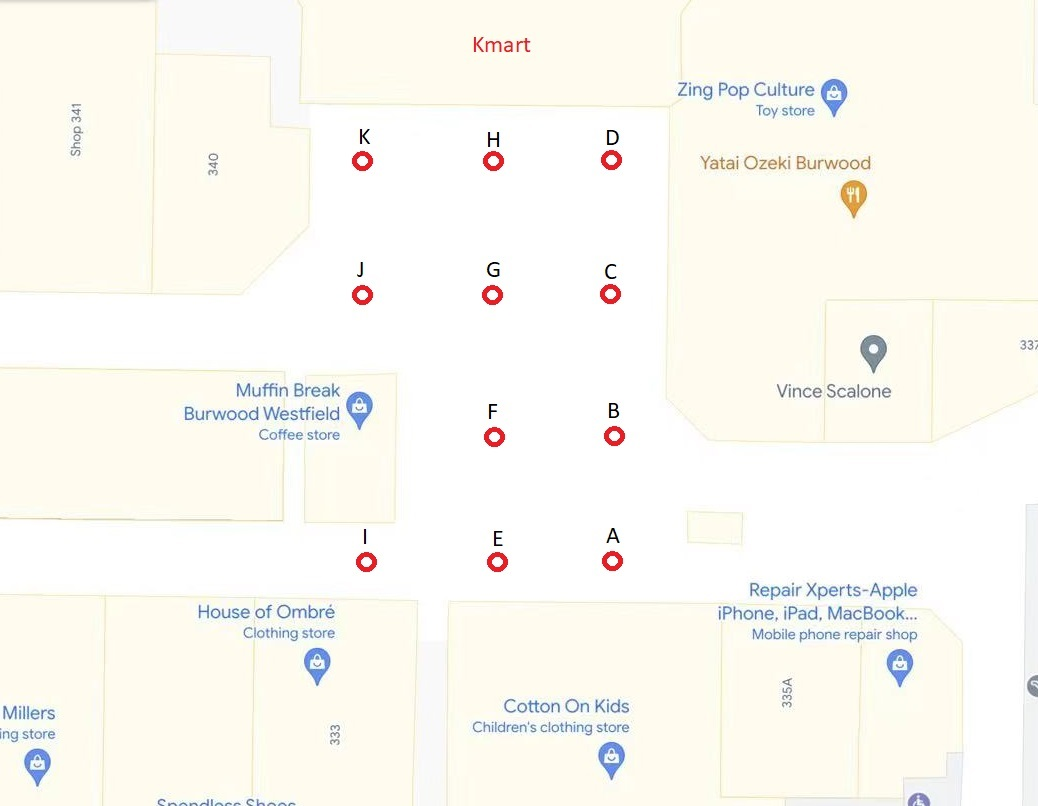
<div style="text-align: right"> <b>Credit to Google Map    </b></div>

In [11]:
# Dataset_1 Dataset (Collect at 22/07/2022 - 9:29pm ~ 10:00pm)
# Dataset_2 Dataset (Collect at 23/07/2022 - 9:00pm ~ 10:30pm)
# Read Project Dataset
ProjectDataset_RootFile = "BurwoodL3 DataCollection"
Datasets = os.listdir(ProjectDataset_RootFile)

# Loop All dataset and Print Tables 
for dataset in range(len(Datasets)):
    DS_filePath = os.path.join(ProjectDataset_RootFile, Datasets[dataset])

    # Dataset Data 
    ep1_datasetname = []
    NO_SSID = []
    NO_BSSID = []
    NO_2d4GHz = []
    NO_5GHz = []
    Dataset_1_Info = []
    Dataset_1_2d4_info = []

    

    for i in os.listdir(DS_filePath):
        # Temporary Counter
        SSID_Counter = []
        BSSID_Counter = 0
        f_2d4Ghz = 0
        f_5Ghz = 0
        TempFre_2d4 = [0]*14

        # Join path
        final_path = os.path.join(DS_filePath, i)
        DS_File = open(final_path, 'r').read()
        result = Pre_Analysis(DS_File)

        # Number of BSSID 
        BSSID_Counter = len(result)
        NO_BSSID.append(BSSID_Counter)

        # Number of 2.4GHz and 5GHz
        for per_bssid in result:
            # Count 2.4 Channel number

            # Count SSID 
            SSID_Counter.append(per_bssid[0])

            # Count 2_4GHz and 5GHz 
            if per_bssid[2] == "2.4 GHz":
                # Count number of 2.4 Frequency
                f_2d4Ghz+=1

                # Count frequency Channel number 
                TempFre_2d4[int(per_bssid[3])]+=1

            else:
                f_5Ghz+=1

        # Append Final Value
        ep1_datasetname.append(i)
        NO_SSID.append(len(list(set(SSID_Counter))))
        NO_2d4GHz.append(f_2d4Ghz)
        NO_5GHz.append(f_5Ghz)
        TempFre_2d4[0] = i[0:9]
        Dataset_1_2d4_info.append(TempFre_2d4)


    # Append Dataset_1 location data to table 
    for i in range(len(ep1_datasetname)):
        temp_arr = []
        temp_arr.append(ep1_datasetname[i])
        temp_arr.append(NO_SSID[i])
        temp_arr.append(NO_BSSID[i])
        temp_arr.append(NO_2d4GHz[i])
        temp_arr.append(NO_5GHz[i])

        Dataset_1_Info.append(temp_arr)

    Dataset_1_info_head = ["Filename","NO. SSID", "NO. BSSID", "NO. 2.4GHz", "NO. 5GHz"]
    print("\n Dataset " + str(dataset + 1) + " - Information Summary: \n\n" + tabulate(Dataset_1_Info, headers=Dataset_1_info_head) + "\n\n")

    Dataset_1_2d4_head = ["Location","CH 1", "CH 2", "CH 2", "CH 4","CH 5", "CH 6", "CH 7", "CH 8","CH 9", "CH 10", "CH 11", "CH 12", "CH 13", "CH 14"]
    print("\n Dataset " + str(dataset + 1) + " - 2.4 Frequency Channel Count: \n\n" + tabulate(Dataset_1_2d4_info, headers=Dataset_1_2d4_head) + "\n\n")




 Dataset 1 - Information Summary: 

Filename         NO. SSID    NO. BSSID    NO. 2.4GHz    NO. 5GHz
-------------  ----------  -----------  ------------  ----------
LocationA.txt          46          132            42          90
LocationB.txt          44          122            53          69
LocationC.txt          43          108            37          71
LocationD.txt          41          105            41          64
LocationE.txt          44          125            39          86
LocationF.txt          40          108            43          65
LocationG.txt          34           99            35          64
LocationH.txt          39          139            43          96
LocationI.txt          54          131            45          86
LocationJ.txt          53          125            37          88
LocationK.txt          43          126            59          67



 Dataset 1 - 2.4 Frequency Channel Count: 

Location      CH 1    CH 2    CH 2    CH 4    CH 5    CH 6    CH 7    C

## Project Detection Point and Test Location:
- Burwood Westfield level 2 (Kmart area) 
- Detection Point 
    - Use two Datasets (Data Collection at different day)
- Testing Point 
    - Data collection done at the last date
  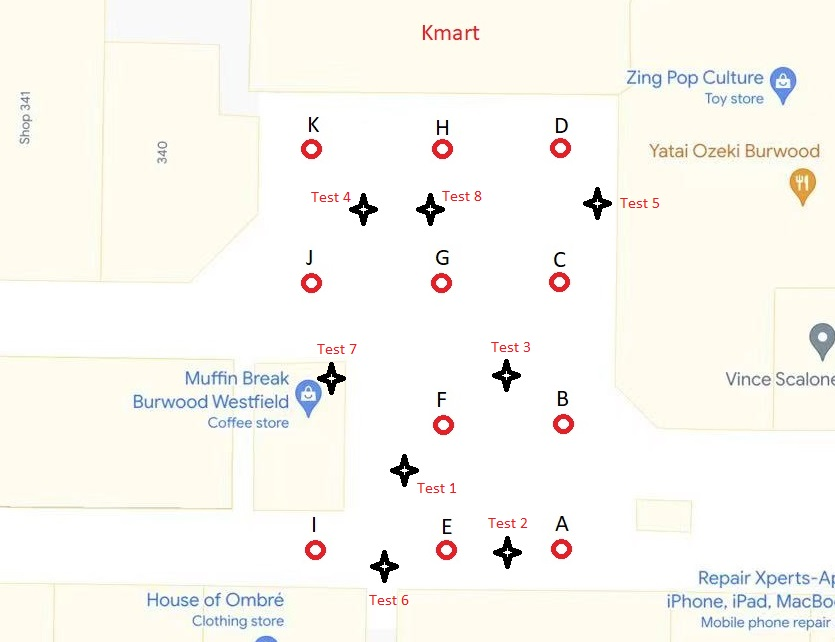

#### Array Index Describtion 
    # Result[i][0]: SSID 
    # Result[i][1]: BSSID 
    # Result[i][2]: Frequency (2.4 Or 5 GHz)
    # Result[i][3]: Frequency Channel 
    # Result[i][4]: Calculated Distance 

In [14]:
# Load the test Data Set and compare to the Location Data Collection 

## Load Test Set
Test_FilePath = "BurwoodL3 TestData"
Testset_name = os.listdir(Test_FilePath)[0]

Testsets_Result = Pre_Analysis(open(os.path.join(Test_FilePath, Testset_name), 'r').read())

print(Testset_name)

Test1.txt


In [49]:
########################################### Get Both 2.4 and 5GHz for the final result counting
# Path Location 
# Detection Point Set 
Filepath = "BurwoodL3 DataCollection"

# Test location Set 
Test_FilePath = "BurwoodL3 TestData"
Testset_name = os.listdir(Test_FilePath)

Datasets_Name = []
fileDBName = []

# Overall Table
LocationCompare_Table = []

# Obtain how many dataset and store 
for fileName in os.listdir(Filepath):
    Datasets_Name.append(fileName)
    
# Obtain Selected Point Location 
for fileDBname in os.listdir(Filepath + "/" + Datasets_Name[0]):
    fileDBName.append(fileDBname)
    
# Loop the Test set
for testLocal in Testset_name:
    Testsets_Result = Pre_Analysis(open(os.path.join(Test_FilePath, testLocal), 'r').read())
    
    # Temp Table
    Temp_LocationCompare_Table = []
    Temp_LocationCompare_Table.append(testLocal)
    
    # For Calcualte the Lowest Set 
    StoreDistance = []

    # Loop Database Locations 
    for db in fileDBName:
        # Read DB dataset
        DB_Result = readMultiDB(Filepath, Datasets_Name, db)

        # Temp Variable
        distance1 = []
        distance2 = []

        for i in range(len(Testsets_Result)):
            for j in range(len(DB_Result)):
                # Compare SSID, BSSID, Frequency and Store the Match Distance value
                if Testsets_Result[i][0] == DB_Result[j][0] and Testsets_Result[i][1] == DB_Result[j][1] and Testsets_Result[i][2] == DB_Result[j][2]:
                    distance1.append(Testsets_Result[i][4])
                    distance2.append(DB_Result[j][4])

        StoreDistance.append([db, NDD(distance1, distance2)])
        Temp_LocationCompare_Table.append(NDD(distance1, distance2))

    Cloest_Result = searchLowestDistance(StoreDistance).replace("Location", "LOC ")[0:5]
    Temp_LocationCompare_Table.append(Cloest_Result)
    LocationCompare_Table.append(Temp_LocationCompare_Table)

# Print Table 
Dataset_info_head = ["File","LOC A","LOC B","LOC C","LOC D","LOC E","LOC F","LOC G","LOC H","LOC I","LOC J","LOC K", "Result"]
print("This Result get 2.4 and 5GHz Result: \n\n" + tabulate(LocationCompare_Table, headers=Dataset_info_head) + "\n\n")


This Result get 2.4 and 5GHz Result: 

File          LOC A    LOC B     LOC C    LOC D     LOC E     LOC F     LOC G     LOC H     LOC I     LOC J    LOC K  Result
---------  --------  -------  --------  -------  --------  --------  --------  --------  --------  --------  -------  --------
Test1.txt  184.271   314.54   182.817   274.763  255.839   174.989    90.3404  428.461   278.545   125.28    388.757  LOC G
Test2.txt  140.684   189.918  116.018   197.746  277.034    67.1319   94.9786  306.549   279.572   166.034   281.382  LOC F
Test3.txt   76.2393  178.487   95.4962  191.024   99.6505   35.1576   49.5937   78.1801   35.4706  143.937   231.698  LOC F
Test4.txt   88.5454  200.703  138.239   286.912  251.777   185.887    70.9737  440.612   270.956   142.644   251.263  LOC G
Test5.txt   56.2961  102.305   84.4323  323.014  194.435   158.907    65.2971  374.55    194.423   184.06    220.871  LOC A
Test6.txt  120.618   295.43   212.466   233.91   153.411    72.6244   92.5146  167.086   

In [53]:
########################################### Get Both 2.4 GHz for the final result counting
# Path Location 
# Detection Point Set 
Filepath = "BurwoodL3 DataCollection"

# Test location Set 
Test_FilePath = "BurwoodL3 TestData"
Testset_name = os.listdir(Test_FilePath)

Datasets_Name = []
fileDBName = []

# Overall Table
LocationCompare_Table = []

# Obtain how many dataset and store 
for fileName in os.listdir(Filepath):
    Datasets_Name.append(fileName)
    
# Obtain Selected Point Location 
for fileDBname in os.listdir(Filepath + "/" + Datasets_Name[0]):
    fileDBName.append(fileDBname)
    
# Loop the Test set
for testLocal in Testset_name:
    Testsets_Result = Pre_Analysis(open(os.path.join(Test_FilePath, testLocal), 'r').read())
    
    # Temp Table
    Temp_LocationCompare_Table = []
    Temp_LocationCompare_Table.append(testLocal)
    
    # For Calcualte the Lowest Set 
    StoreDistance = []

    # Loop Database Locations 
    for db in fileDBName:
        # Read DB dataset
        DB_Result = readMultiDB(Filepath, Datasets_Name, db)

        # Temp Variable
        distance1 = []
        distance2 = []

        for i in range(len(Testsets_Result)):
            for j in range(len(DB_Result)):
                # Compare SSID, BSSID, Frequency and Store the Match Distance value
                if Testsets_Result[i][0] == DB_Result[j][0] and Testsets_Result[i][1] == DB_Result[j][1] and Testsets_Result[i][2] == DB_Result[j][2] and DB_Result[j][2] == "2.4 GHz":
                    distance1.append(Testsets_Result[i][4])
                    distance2.append(DB_Result[j][4])

        StoreDistance.append([db, NDD(distance1, distance2)])
        Temp_LocationCompare_Table.append(NDD(distance1, distance2))

    Cloest_Result = searchLowestDistance(StoreDistance).replace("Location", "LOC ")[0:5]
    Temp_LocationCompare_Table.append(Cloest_Result)
    LocationCompare_Table.append(Temp_LocationCompare_Table)

# Print Table 
Dataset_info_head = ["File","LOC A","LOC B","LOC C","LOC D","LOC E","LOC F","LOC G","LOC H","LOC I","LOC J","LOC K", "Result"]
print("This Result get 2.4 GHz Frequency: \n\n" + tabulate(LocationCompare_Table, headers=Dataset_info_head) + "\n\n")


This Result get 2.4 GHz Frequency: 

File          LOC A     LOC B      LOC C    LOC D     LOC E     LOC F     LOC G     LOC H     LOC I     LOC J    LOC K  Result
---------  --------  --------  ---------  -------  --------  --------  --------  --------  --------  --------  -------  --------
Test1.txt  156.27    229.357   126.562    259.3    252.965   169.718   64.5499   419.655   274.737   111.226   384.966  LOC G
Test2.txt  122.537    34.1409   57.844    184.712  269.462    50.2259  75.1358   298.372   275.26    158.288   273.142  LOC B
Test3.txt   42.5519   16.4084    8.95912  184.629   83.9593   13.8992   6.75701   55.7516   15.393   138.147   226.526  LOC G
Test4.txt   36.1569  177.579   126.78     275.907  246.783   179.872   55.5976   430.49    268.713   133.73    248.038  LOC A
Test5.txt   29.9107   37.2319   50.7851   311.055  193.764   156.6     39.4238   360.193   191.925   179.349   216.529  LOC A
Test6.txt   41.5849  182.126   123.334    211.442  131.584    50.7333  13.104

In [56]:
########################################### Get 5GHz for the final result counting
# Path Location 
# Detection Point Set 
Filepath = "BurwoodL3 DataCollection"

# Test location Set 
Test_FilePath = "BurwoodL3 TestData"
Testset_name = os.listdir(Test_FilePath)

Datasets_Name = []
fileDBName = []

# Overall Table
LocationCompare_Table = []

# Obtain how many dataset and store 
for fileName in os.listdir(Filepath):
    Datasets_Name.append(fileName)
    
# Obtain Selected Point Location 
for fileDBname in os.listdir(Filepath + "/" + Datasets_Name[0]):
    fileDBName.append(fileDBname)
    
# Loop the Test set
for testLocal in Testset_name:
    Testsets_Result = Pre_Analysis(open(os.path.join(Test_FilePath, testLocal), 'r').read())
    
    # Temp Table
    Temp_LocationCompare_Table = []
    Temp_LocationCompare_Table.append(testLocal)
    
    # For Calcualte the Lowest Set 
    StoreDistance = []

    # Loop Database Locations 
    for db in fileDBName:
        # Read DB dataset
        DB_Result = readMultiDB(Filepath, Datasets_Name, db)

        # Temp Variable
        distance1 = []
        distance2 = []

        for i in range(len(Testsets_Result)):
            for j in range(len(DB_Result)):
                # Compare SSID, BSSID, Frequency and Store the Match Distance value
                if Testsets_Result[i][0] == DB_Result[j][0] and Testsets_Result[i][1] == DB_Result[j][1] and Testsets_Result[i][2] == DB_Result[j][2] and DB_Result[j][2] == "5 GHz":
                    distance1.append(Testsets_Result[i][4])
                    distance2.append(DB_Result[j][4])

        StoreDistance.append([db, NDD(distance1, distance2)])
        Temp_LocationCompare_Table.append(NDD(distance1, distance2))

    Cloest_Result = searchLowestDistance(StoreDistance).replace("Location", "LOC ")[0:5]
    Temp_LocationCompare_Table.append(Cloest_Result)
    LocationCompare_Table.append(Temp_LocationCompare_Table)

# Print Table 
Dataset_info_head = ["File","LOC A","LOC B","LOC C","LOC D","LOC E","LOC F","LOC G","LOC H","LOC I","LOC J","LOC K", "Result"]
print("This Result get 5 GHz Frequency: \n\n" + tabulate(LocationCompare_Table, headers=Dataset_info_head) + "\n\n")


This Result get 5 GHz Frequency: 

File          LOC A     LOC B     LOC C     LOC D    LOC E    LOC F    LOC G     LOC H    LOC I    LOC J    LOC K  Result
---------  --------  --------  --------  --------  -------  -------  -------  --------  -------  -------  -------  --------
Test1.txt   97.6488  215.245   131.924    90.8767  38.2384  42.6247  63.2036   86.4214  45.8992  57.6524  54.161   LOC E
Test2.txt   69.1132  186.824   100.57     70.6041  64.3258  44.5428  58.0993   70.3306  48.9104  50.1222  67.5943  LOC F
Test3.txt   63.2595  177.731    95.075    49.0144  53.6754  32.2935  49.1312   54.8078  31.9565  40.4156  48.6835  LOC I
Test4.txt   80.8267   93.5287   55.1077   78.7018  49.8971  46.9065  44.1155   93.8978  34.7874  49.6354  40.1266  LOC I
Test5.txt   47.6928   95.2891   67.4513   87.0783  16.1386  26.9798  52.0526  102.708   31.0687  41.3768  43.5791  LOC E
Test6.txt  113.222   232.614   173.004   100.031   78.8717  51.9657  91.5817  116.262   64.1292  75.0154  60.7338 

#### Explaination: 
    - Due to the 5GHz signal fluctuating a lot if any obstacle, for example if human body block the 5GHz signal antennas can end up causing 30 meters or more deviation. The best method to detect the WIFI location is using a 2.4 GHz frequency when there are a lot of obstacles exist.
    - 5GHz Frequency is suitable for small and open areas located (need to ensure 5GHz frequency signal receivers signal will not be blocked). 
    - 2.4 GHz and 5 GHz 

## Experiment: Indicate WIFI Fingerprinting Issue 

#### Experiment 1: RSS Value in different Time
 - This experiment done at Burwood Westfield shopping center Ground Floor (In front of Coles)
 - The dataset collection at "22/07/2022 9:02:00pm"

In [61]:
# Read Experiment Path 
## Load Test Set
Experiment_RootFile = "Experiment dataset"
ep1_filename = "Experiment 1 - RSS Value in different Time"
ep1_filepathJoin = os.path.join(Experiment_RootFile, ep1_filename)

# Show Data
ep1_datasetname = []
NO_SSID = []
NO_BSSID = []
NO_2d4GHz = []
NO_5GHz = []


# Loop file name and append to "ep1_datasetname"
for i in os.listdir(ep1_filepathJoin):
    # Temporary Counter
    SSID_Counter = []
    BSSID_Counter = 0
    f_2d4Ghz = 0
    f_5Ghz = 0
    
    # Join path
    final_path = os.path.join(ep1_filepathJoin, i)
    ep1_file = open(final_path, 'r').read()
    result = Pre_Analysis(ep1_file)
    
    # Number of BSSID 
    BSSID_Counter = len(result)
    NO_BSSID.append(BSSID_Counter)
    
    # Number of 2.4GHz and 5GHz
    for per_bssid in result:
        # Count SSID 
        SSID_Counter.append(per_bssid[0])
        
        # Count 2_4GHz and 5GHz 
        if per_bssid[2] == "2.4 GHz":
            f_2d4Ghz+=1
        else:
            f_5Ghz+=1
    
    ep1_datasetname.append(i)
    NO_SSID.append(len(list(set(SSID_Counter))))
    NO_2d4GHz.append(f_2d4Ghz)
    NO_5GHz.append(f_5Ghz)
    


tabulate_Table = []
for i in range(len(ep1_datasetname)):
    temp_arr = []
    temp_arr.append(ep1_datasetname[i])
    temp_arr.append(ep1_datasetname[i][9])
    temp_arr.append(NO_SSID[i])
    temp_arr.append(NO_BSSID[i])
    temp_arr.append(NO_2d4GHz[i])
    temp_arr.append(NO_5GHz[i])
    
    tabulate_Table.append(temp_arr)

Table_head = ["Filename", "Waited time (mins)","NO. SSID", "NO. BSSID", "NO. 2.4GHz", "NO. 5GHz"]
print("\n" + tabulate(tabulate_Table, headers=Table_head, tablefmt='orgtbl'))
print("\nNumber of SSID and BSSID getting stable after 2 mins of waited time by using Window API, for the actual Data collect of the project should wait around 2 mins before RSS data collection.")


| Filename       |   Waited time (mins) |   NO. SSID |   NO. BSSID |   NO. 2.4GHz |   NO. 5GHz |
|----------------+----------------------+------------+-------------+--------------+------------|
| 22072022_0.txt |                    0 |         53 |         126 |           60 |         66 |
| 22072022_1.txt |                    1 |         36 |          61 |           41 |         20 |
| 22072022_2.txt |                    2 |         24 |          48 |           32 |         16 |
| 22072022_3.txt |                    3 |         24 |          46 |           31 |         15 |
| 22072022_4.txt |                    4 |         25 |          44 |           30 |         14 |
| 22072022_7.txt |                    7 |         26 |          44 |           31 |         13 |

Number of SSID and BSSID getting stable after 2 mins of waited time by using Window API, for the actual Data collect of the project should wait around 2 mins before RSS data collection.


#### Experiment 2: Compare the distance between Stable Dataset and test dataset
 - Burwood Westfield level 2 (Kmart area)
 - The Detection point x 4 - Use dataset 2 (RSS collection at location and waited 3 mins)
 - The Testing Point (Unstable) x 2 - I will walk to the location and run the Window API right away
 - The Testing Point (Stable) x 2 - RSS Collection with minimum of 2 minutes of wait time

 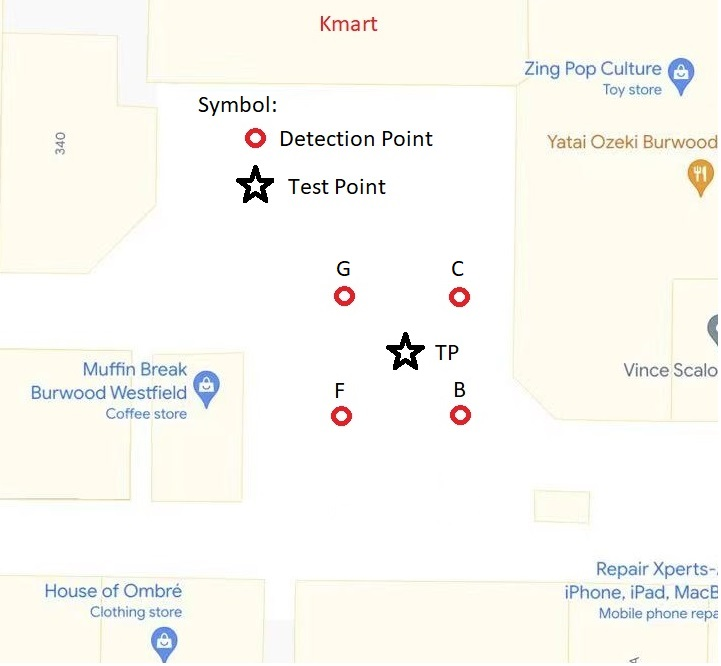

In [98]:
# Read Experiment Path 
## Load Test Set
Experiment_RootFile = "Experiment dataset"
ep2_filename = "Experiment 2 - Calcualte Distance"
DP_Dataset = "DetectionPoint_Dataset"
TP_Dataset = "Testpoint_dataset"

# Table Array 
ep2_table_arr = []

# Loop Test Point Set 
for i in os.listdir(os.path.join(Experiment_RootFile, ep2_filename, TP_Dataset)):
    # Temp table array 
    temp_ep2_table_arr = []
    temp_ep2_table_arr.append(i)
    
    Testsets_Result = Pre_Analysis(open(os.path.join(Experiment_RootFile, ep2_filename, TP_Dataset, i), 'r').read())
    
    # Loop DP Dataset to compare the distance 
    for DP_dataset in os.listdir(os.path.join(Experiment_RootFile, ep2_filename, DP_Dataset)):
        DB_Result = Pre_Analysis(open(os.path.join(Experiment_RootFile, ep2_filename, DP_Dataset, DP_dataset), 'r').read())
        
        # Temp Variable
        distance1 = []
        distance2 = []
        
        for i in range(len(Testsets_Result)):
            for j in range(len(DB_Result)):
                # Compare SSID, BSSID, Frequency and Store the Match Distance value
                if Testsets_Result[i][0] == DB_Result[j][0] and Testsets_Result[i][1] == DB_Result[j][1] and Testsets_Result[i][2] == DB_Result[j][2]:
                    distance1.append(Testsets_Result[i][4])
                    distance2.append(DB_Result[j][4])

        temp_ep2_table_arr.append(NDD(distance1, distance2))
        
    ep2_table_arr.append(temp_ep2_table_arr)

Table_head = ["TestFile", "LOC B", "LOC C","LOC F", "LOC G"]
print("\nCompare Test Dataset by Both Frequency \n\n" + tabulate(ep2_table_arr, headers=Table_head, tablefmt='orgtbl'))


######################### 2.4 GHz
# Table Array 
ep2_table_arr = []

# Loop Test Point Set 
for i in os.listdir(os.path.join(Experiment_RootFile, ep2_filename, TP_Dataset)):
    # Temp table array 
    temp_ep2_table_arr = []
    temp_ep2_table_arr.append(i)
    
    Testsets_Result = Pre_Analysis(open(os.path.join(Experiment_RootFile, ep2_filename, TP_Dataset, i), 'r').read())
    
    # Loop DP Dataset to compare the distance 
    for DP_dataset in os.listdir(os.path.join(Experiment_RootFile, ep2_filename, DP_Dataset)):
        DB_Result = Pre_Analysis(open(os.path.join(Experiment_RootFile, ep2_filename, DP_Dataset, DP_dataset), 'r').read())
        
        # Temp Variable
        distance1 = []
        distance2 = []
        
        for i in range(len(Testsets_Result)):
            for j in range(len(DB_Result)):
                # Compare SSID, BSSID, Frequency and Store the Match Distance value
                if Testsets_Result[i][0] == DB_Result[j][0] and Testsets_Result[i][1] == DB_Result[j][1] and Testsets_Result[i][2] == DB_Result[j][2] and DB_Result[j][2] == "2.4 GHz":
                    distance1.append(Testsets_Result[i][4])
                    distance2.append(DB_Result[j][4])

        temp_ep2_table_arr.append(NDD(distance1, distance2))
        
    ep2_table_arr.append(temp_ep2_table_arr)

Table_head = ["TestFile", "LOC B", "LOC C","LOC F", "LOC G"]
print("\n" + ("=" * 70) +  "\nCompare Test Dataset by using 2.4GHz Frequency \n\n" + tabulate(ep2_table_arr, headers=Table_head, tablefmt='orgtbl'))

######################### 5 GHz
# Table Array 
ep2_table_arr = []

# Loop Test Point Set 
for i in os.listdir(os.path.join(Experiment_RootFile, ep2_filename, TP_Dataset)):
    # Temp table array 
    temp_ep2_table_arr = []
    temp_ep2_table_arr.append(i)
    
    Testsets_Result = Pre_Analysis(open(os.path.join(Experiment_RootFile, ep2_filename, TP_Dataset, i), 'r').read())
    
    # Loop DP Dataset to compare the distance 
    for DP_dataset in os.listdir(os.path.join(Experiment_RootFile, ep2_filename, DP_Dataset)):
        DB_Result = Pre_Analysis(open(os.path.join(Experiment_RootFile, ep2_filename, DP_Dataset, DP_dataset), 'r').read())
        
        # Temp Variable
        distance1 = []
        distance2 = []
        
        for i in range(len(Testsets_Result)):
            for j in range(len(DB_Result)):
                # Compare SSID, BSSID, Frequency and Store the Match Distance value
                if Testsets_Result[i][0] == DB_Result[j][0] and Testsets_Result[i][1] == DB_Result[j][1] and Testsets_Result[i][2] == DB_Result[j][2] and DB_Result[j][2] == "5 GHz":
                    distance1.append(Testsets_Result[i][4])
                    distance2.append(DB_Result[j][4])

        temp_ep2_table_arr.append(NDD(distance1, distance2))
        
    ep2_table_arr.append(temp_ep2_table_arr)

Table_head = ["TestFile", "LOC B", "LOC C","LOC F", "LOC G"]
print("\n" + ("=" * 70) +  "\nCompare Test Dataset by using 5GHz Frequency \n\n" + tabulate(ep2_table_arr, headers=Table_head, tablefmt='orgtbl'))


Compare Test Dataset by Both Frequency 

| TestFile    |   LOC B |   LOC C |   LOC F |   LOC G |
|-------------+---------+---------+---------+---------|
| Test_s1.txt | 369.197 | 171.967 | 112.585 | 111.92  |
| Test_s2.txt | 406.604 | 321.86  | 276.074 | 173.153 |
| Test_u1.txt | 391.714 | 198.34  | 270.694 | 121.448 |
| Test_u2.txt | 401.437 | 194.697 | 166.46  | 182.465 |

Compare Test Dataset by using 2.4GHz Frequency 

| TestFile    |    LOC B |    LOC C |    LOC F |    LOC G |
|-------------+----------+----------+----------+----------|
| Test_s1.txt |  34.9374 |  11.993  |  64.5378 |  11.803  |
| Test_s2.txt |  11.4091 |  77.9769 | 117.315  |  40.2632 |
| Test_u1.txt | 103.735  | 109.402  | 254.608  |  41.6804 |
| Test_u2.txt | 151.815  |  76.6085 | 140.178  | 155.223  |

Compare Test Dataset by using 5GHz Frequency 

| TestFile    |   LOC B |   LOC C |    LOC F |    LOC G |
|-------------+---------+---------+----------+----------|
| Test_s1.txt | 367.541 | 171.548 |  92.2508 | 1